In [ ]:
import splitfolders
splitfolders.ratio("natural_images", output="data", seed=69, ratio=(.8, .2), group_prefix=None) # default values

Start From Here

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [1]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale=1./255, 
                                    featurewise_center=False,  # set input mean to 0 over the dataset
                                    samplewise_center=False,  # set each sample mean to 0
                                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                    samplewise_std_normalization=False,  # divide each input by its std
                                    zca_whitening=False,  # apply ZCA whitening
                                    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                                    zoom_range = 0.2, # Randomly zoom image 
                                    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                    horizontal_flip=True,  # randomly flip images
                                    vertical_flip=False)  # randomly flip images



test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory('data/train', 
                                                    target_size = (100, 100), 
                                                    batch_size = 32, 
                                                    class_mode = 'categorical',
                                                    seed=69)
                                                    

validation_generator = test_datagen.flow_from_directory('data/val',
                                                        target_size=(100, 100),
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        seed=69)
                                                        

Using TensorFlow backend.


Found 5516 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [2]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (100, 100, 3)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

          
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation = "softmax"))
          
          
optimizer = Adam(lr=0.001, epsilon=1e-08)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
          
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            mode = 'max', 
                                            min_lr=0.00001)

Using TensorFlow backend.


In [3]:
model.load_weights('checkpoint/checkpoint.hdf5')

In [4]:
from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(filepath='checkpoint/checkpoint.hdf5',
                                           save_weights_only=False,
                                           monitor='val_accuracy',
                                           verbose = 1,
                                           mode='max',
                                           save_best_only=True)




history = model.fit(train_generator, 
                    steps_per_epoch=173, 
                    epochs=4, 
                    validation_data=validation_generator, 
                    validation_steps=44, 
                    callbacks=[learning_rate_reduction, model_checkpoint_callback])




model.save('object_classification_model.h5')



Epoch 1/4
173/173 [==============================] - 467s 3s/step - loss: 0.2610 - accuracy: 0.9003 - val_loss: 0.5888 - val_accuracy: 0.9219

Epoch 00001: val_accuracy improved from -inf to 0.92191, saving model to checkpoint/checkpoint.hdf5
Epoch 2/4
173/173 [==============================] - 450s 3s/step - loss: 0.2340 - accuracy: 0.9162 - val_loss: 0.1728 - val_accuracy: 0.9342

Epoch 00002: val_accuracy improved from 0.92191 to 0.93420, saving model to checkpoint/checkpoint.hdf5
Epoch 3/4
173/173 [==============================] - 439s 3s/step - loss: 0.2252 - accuracy: 0.9148 - val_loss: 0.1234 - val_accuracy: 0.9313

Epoch 00003: val_accuracy did not improve from 0.93420
Epoch 4/4
173/173 [==============================] - 434s 3s/step - loss: 0.2179 - accuracy: 0.9188 - val_loss: 0.0080 - val_accuracy: 0.9299

Epoch 00004: val_accuracy did not improve from 0.93420


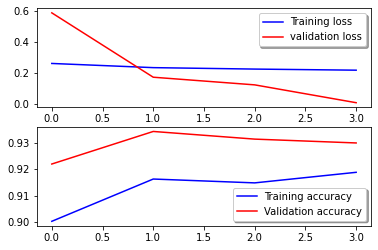

In [8]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

Predicting image


In [9]:
print(validation_generator.class_indices)

{'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}


In [16]:
from PIL import Image
import numpy as np
from skimage import transform

np_image = Image.open('test_data/bike.jpg')
np_image = np.array(np_image).astype('float32')/255
np_image = transform.resize(np_image, (100, 100, 3))
np_image = np.expand_dims(np_image, axis=0)


prediction = np.argmax(model.predict(np_image))
print(prediction)

6


In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 128)     9728      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 256)      